In [1]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from itertools import combinations
from random import randrange

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created Directory : ", directory)
    else:
        print("Directory already existed : ", directory)
    return directory

def abs_dis(a, b, target):
    return abs(np.linalg.norm(np.array(a) - np.array(b)) - target)

def supercell_gen(cell_num1, cell_num2):
    atom_pos1 = cell_num1*2 + 1
    atom_pos2 = cell_num2*2 + 1
    zero_cell = np.zeros(((atom_pos1, atom_pos2)))
    for i in range(atom_pos1):
        for j in range(atom_pos2):
            if i%2 == 1:
                zero_cell[i][j] = abs(j%2)
            elif i%2 == 0:
                zero_cell[i][j] = 1 - abs(j%2)
    return zero_cell

In [20]:
inp = torch.FloatTensor([[1,2],[3,4],[5,6]])
ind_c = torch.combinations(torch.arange(inp.size(0)), r=2)
inp_c = inp[ind_c]
inp_res = inp_c[:, 1]-inp_c[:, 0]
torch.norm(inp_res, dim=1)

tensor([2.8284, 5.6569, 2.8284])

In [17]:
inp_c[:,0]

tensor([[1., 2.],
        [1., 2.],
        [3., 4.]])

In [21]:
torch.int(torch.sqrt(100))

TypeError: sqrt(): argument 'input' (position 1) must be Tensor, not int

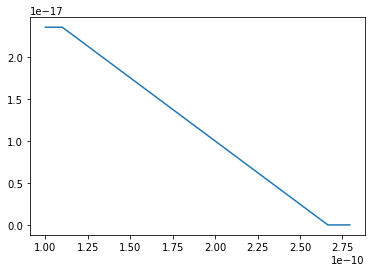

2.7934954e-10


In [29]:
#*レナードジョーンズ
def e_(epsilon, sigma, r):
    return 4*epsilon*((sigma/r)**12 - (sigma/r)**6)

epsilon = 7.545*1.380649e-23
sigma = 2.49e-10 #*Angstorm -> meter
r = torch.ones(1, requires_grad=True)
with torch.no_grad():
    r *= 1e-10
alpha_optimizer = torch.optim.Adam([r], lr=1e-11)
phi_list, r_list = [], []
r_list.append(r.detach().numpy()[0])
phi_list.append(e_(epsilon, sigma, r.detach().numpy()[0]))

for i in range(100000):
    r_loss = e_(epsilon, sigma, r)
    alpha_optimizer.zero_grad()
    r_loss.backward()
    alpha_optimizer.step()
    if i%10000==0 or i == 0:
        clear_output(True)
        r_list.append(r.detach().numpy()[0])
        phi_list.append(r_loss.detach().numpy())
        plt.plot(r_list, phi_list)
        plt.show()

print(r_list[-1])

In [2]:
coord = []
for j in range(3):
    for k in range(3):
        rand1 = np.random.rand()*0.5-1/4
        rand2 = np.random.rand()*0.5-1/4
        coord.append([1.15*j+rand1, 1.15*k+rand2])

coord = np.array(coord)
atom_ind = np.random.choice(9, 5)
coord[atom_ind]

array([[ 2.4464479 ,  2.30386771],
       [ 1.36327971,  0.95785306],
       [ 1.36327971,  0.95785306],
       [ 2.37987058,  1.12415801],
       [-0.03764879,  2.3969778 ]])

In [7]:
cell = supercell_gen(2,2)
cell_t = np.array(cell, dtype=bool)
coord = np.concatenate([np.where(cell_t)[0].reshape(-1,1),np.where(cell_t)[1].reshape(-1,1)], 1)*init_dis*np.sqrt(2)/2
cell_t

array([[ True, False,  True, False,  True],
       [False,  True, False,  True, False],
       [ True, False,  True, False,  True],
       [False,  True, False,  True, False],
       [ True, False,  True, False,  True]])

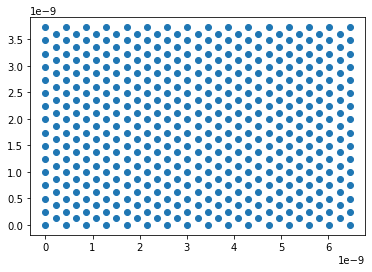

In [107]:
cell = supercell_gen(15, 15)
cell_t = np.array(cell, dtype=bool)
init_weight = np.array([math.sqrt(3)/2*init_dis, 1/2*init_dis])
coord = np.concatenate([np.where(cell_t)[0].reshape(-1,1),
                        np.where(cell_t)[1].reshape(-1,1)], 1)*init_weight

plt.scatter(coord[:,0], coord[:,1])

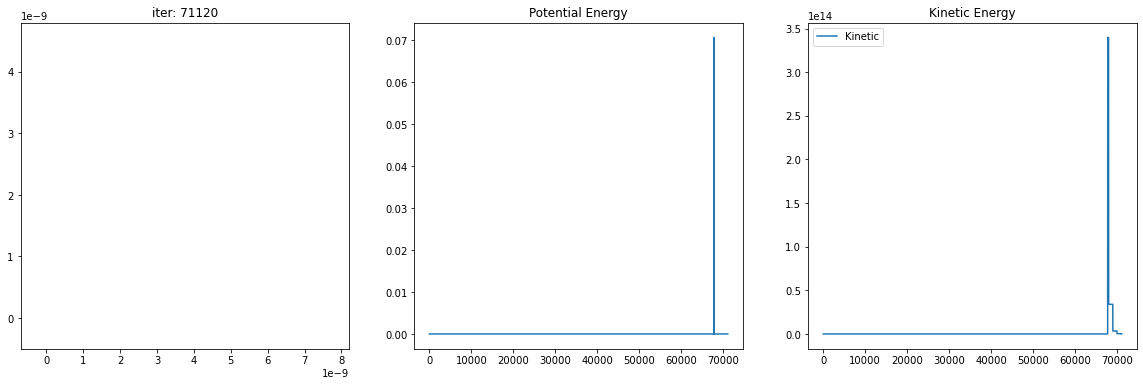

KeyboardInterrupt: 

In [117]:
#*Taking gradient of x, y coordinates in square cluster
def e_(epsilon, sigma, r):
    r_cut = 2**(1/6)*sigma
    ind_exe = np.where(r > r_cut)[0]
    phi = 4*epsilon*((sigma/r)**12 - (sigma/r)**6)
    grad = 4*epsilon*(12/sigma*((sigma/r)**13) - 6/sigma*((sigma/r)**7))
    grad[ind_exe[0]] = 0
    # grad = np.clip(grad, None, 5)
    return phi, grad

#*Generating random distributed atoms in matrix
k_b = 1.380649e-23
x_extend, y_extend = 15, 15
#*Define the 1NN distance based on DFT result
init_dis = 4.1/math.sqrt(2)*1e-10

cell = supercell_gen(x_extend, y_extend)
cell_t = np.array(cell, dtype=bool)
init_weight = np.array([math.sqrt(3)/2*init_dis, 1/2*init_dis])
coord = np.concatenate([np.where(cell_t)[0].reshape(-1,1),
                        np.where(cell_t)[1].reshape(-1,1)], 1)*init_weight
atom_num = len(coord)
# region = np.array(region)

#*Set the boundary condition
x_upper, x_lower = (x_extend+1/2)*init_dis*math.sqrt(3), -(1/2)*init_dis*math.sqrt(3)
y_upper, y_lower = (y_extend+1/2)*init_dis, -(1/2)*init_dis
x_region, y_region = (x_extend+1)*init_dis*math.sqrt(3), (y_extend+1)*init_dis

#*Atom list
len_cr = len(coord)//3+randrange(2)
len_co = len(coord)//3+randrange(2)
len_ni = len(coord) - len_cr - len_co

ele_list = np.concatenate([
    np.zeros(len_cr)+1, #*Cr
    np.zeros(len_co),   #*Co
    np.zeros(len_ni)-1, #*Ni
], 0)
np.random.shuffle(ele_list)

ind_cr = np.where(ele_list == 1)[0]
ind_co = np.where(ele_list == 0)[0]
ind_ni = np.where(ele_list == -1)[0]

sigma, epsilon, m = np.ones(len(coord)), np.ones(len(coord)), np.ones(len(coord))

sigma[ind_cr] *= 2.69e-10
sigma[ind_co] *= 2.559e-10
sigma[ind_ni] *= 2.525e-10

epsilon[ind_cr] *= 7.545*k_b
epsilon[ind_co] *= 7.045*k_b
epsilon[ind_ni] *= 7.548*k_b

m[ind_cr] *= 52*1.6605e-27
m[ind_co] *= 58.93*1.6605e-27
m[ind_ni] *= 58.7*1.6605e-27

#*Hyperparameter
dt = 1e-16
iter_time = 100000
temp = 77
alpha = 0.1
#*Initialize the velocity
v_a = np.random.rand(atom_num, 2)*np.sqrt(3*k_b*temp/m.reshape(-1,1))
# v_a = np.zeros((atom_num, 2))
phi_list, kin_list = [], []
path = os.getcwd()
date = 20221010_2
path_new = path+f'/Buffer/{date}'
create_dir(path_new)

for iter in range(iter_time):
    #*Randomly choose atoms for computation
    atom_ind = np.random.choice(atom_num, atom_num//4, replace=False)
    phi_sum = 0
    for ind in range(len(atom_ind)):
        atom = coord[atom_ind[ind]]
        # bound = region[atom_ind[ind]]
        #*Boundary condition
        if atom[0] < x_lower:
            atom[0] += x_region
        elif atom[0] >= x_upper:
            atom[0] -= x_region
        if atom[1] < y_lower:
            atom[1] += y_region
        elif atom[1] >= y_upper:
            atom[1] -= y_region

        neigh_atom = np.delete(coord, atom_ind[ind], axis=0)
        res_atom = neigh_atom-atom
        dis_list = np.linalg.norm(neigh_atom-atom, axis=1)
        #*Delete the extra epsilon and sigma
        epsilon_ = np.delete(epsilon, atom_ind[ind])
        sigma_ = np.delete(sigma, atom_ind[ind])
        m_ = np.delete(m, atom_ind[ind])

        r_phi, r_grad = e_(epsilon_, sigma_, dis_list)
        #*Compute the new coords and v0.5
        #*Nx2
        a_i = -r_grad.reshape(-1,1)*(neigh_atom-atom)/dis_list.reshape(-1,1)/m_.reshape(-1,1)
        a_i = np.sum(a_i, axis=0)
        atom += v_a[atom_ind[ind]]*dt + 1/2*a_i*dt**2

        v_a[atom_ind[ind]] += 1/2*a_i*dt
        #*New Phi and v1
        res_atom = neigh_atom-atom
        dis_list = np.linalg.norm(neigh_atom-atom, axis=1)
        r_phi, r_grad = e_(epsilon_, sigma_, dis_list)
        a_i = -r_grad.reshape(-1,1)*(neigh_atom-atom)/dis_list.reshape(-1,1)/m_.reshape(-1,1)
        a_i = np.sum(a_i, axis=0)
        v_a[atom_ind[ind]] += 1/2*a_i*dt
        coord[atom_ind[ind]] = atom
        #*Normalization
        v_a -= np.sum(v_a, axis=0)/len(v_a)
        phi_sum += np.sum(r_phi)

    kine_e = 1/2*np.sum(m.reshape(-1,1)*v_a**2)
    phi_list.append(phi_sum)
    kin_list.append(kine_e)

    #*Adjusting the velocity under given temperature
    if iter % 1000 == 0:
        temp_now = 2*kine_e/3/(len(coord)-1)/k_b
        s_adjust = np.sqrt((temp+(temp_now-temp)*alpha)/temp_now)
        v_a *= s_adjust

    if iter%(iter_time/10000)==0:
        
        clear_output(True)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

        ax1.scatter(coord[:,0][ind_cr], coord[:,1][ind_cr])
        ax1.scatter(coord[:,0][ind_co], coord[:,1][ind_co])
        ax1.scatter(coord[:,0][ind_ni], coord[:,1][ind_ni])
        ax1.set_title(f'iter: {iter}')
        ax1.set_xlim([-0.7e-9, 8.2e-9])
        ax1.set_ylim([-0.5e-9, 4.8e-9])

        ax2.plot(phi_list, label='Phi')
        ax2.set_title(f'Potential Energy')
        if len(kin_list) > 50:
            ax3.plot(kin_list[50:], label='Kinetic')
        else:
            ax3.plot(kin_list, label='Kinetic')
        ax3.set_title(f'Kinetic Energy')

        extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(path_new+f'/{iter}.png', bbox_inches=extent)

        plt.legend()
        plt.show()

In [61]:
r_c = 2**(1/6)
great_ind = []
for i, j, k in combinations(range(len(coord)), 3):
    a1, a2, a3 = coord[i], coord[j], coord[k]
    if (abs_dis(a1, a2, r_c) < 0.0898
    and abs_dis(a1, a3, r_c) < 0.0898
    and abs_dis(a2, a3, r_c) < 0.0898):
        great_ind.append([i, j, k])

great_ind = np.unique(np.array(great_ind).ravel())
great_ind

array([ 82,  83, 101, 102, 103, 122, 151, 171, 172, 183, 202, 203, 222,
       297, 317, 318, 364, 384, 385])

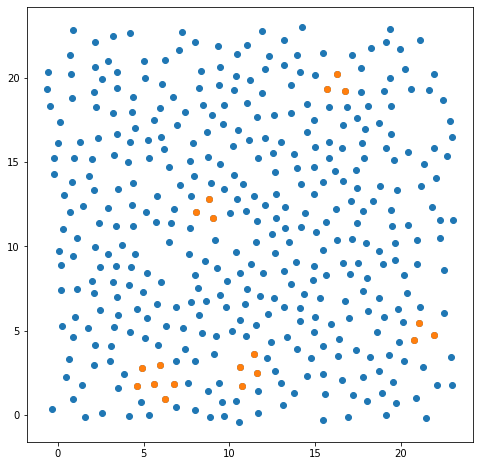

In [62]:
e_coord = coord[great_ind]
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(coord[:,0], coord[:,1])
plt.scatter(e_coord[:,0], e_coord[:,1])

plt.show()

In [49]:
coord_ = []
for j in range(x_extend):
    for k in range(y_extend):
        rand1 = np.random.rand()*1/4-1/8
        rand2 = np.random.rand()*1/4-1/8
        coord_.append([init_dis*j+rand1, init_dis*k+rand2])
        #*Seperate the matrix into several bounded regions
        # region.append([1.12*(j-1/2), 1.12*(j+1/2), 1.12*(k-1/2), 1.12*(k+1/2)])

coord_ = np.array(coord_)